In [15]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [17]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [18]:
season_length = 7 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [19]:
# Generate forecasts for the specified horizon using the sf object
horizon = 90
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) # forecast data
Y_hat_df.head(5) 

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2022-12-31,128.828384,128.900574,128.936142,129.288589
AAPL,2023-01-01,128.661270,128.942734,128.857681,129.300644
AAPL,2023-01-02,128.794540,128.984894,128.850769,128.845276
AAPL,2023-01-03,128.736740,129.027054,128.623489,128.858902
AAPL,2023-01-04,128.390945,129.069214,128.725815,128.910919


In [20]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  24.163825  719.139476  0.153188  26.816776  16.861323

Model: AutoETS
         mae        mse      mape       rmse     smape:
0  22.019805  596.29172  0.139627  24.419085  15.228999

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  23.140523  659.598538  0.146703  25.682651  16.078272

Model: CES
         mae         mse      mape       rmse     smape:
0  22.294536  611.846269  0.141359  24.735526  15.436375

Results for MSFT:
Model: AutoARIMA
         mae        mse      mape       rmse     smape:
0  26.686304  1081.5974  0.095614  32.887648  10.249117

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  29.546519  1312.710245  0.105894  36.231343  11.437559

Model: AutoTheta
         mae          mse     mape       rmse     smape:
0  28.061851  1192.445167  0.10054  34.531799  10.818064

Model: CES
         mae          mse      mape      

In [21]:
cv_df = sf.cross_validation(df=Y_train_df, h=90, n_windows=3, step_size=90, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2021-12-06,2021-12-03,163.023041,158.149750,155.762604,160.536896,159.730896,149.345551,170.116257,159.455826,157.785645,161.159988,160.266327,158.379822,162.248108
AAPL,2021-12-07,2021-12-03,168.801590,156.050781,151.842743,160.258820,159.815887,145.314560,174.317230,159.584229,157.149857,162.173569,160.466400,158.579498,162.447845
AAPL,2021-12-08,2021-12-03,172.647400,154.761078,148.023926,161.498245,159.900894,142.207245,177.594543,159.789810,156.909073,162.706757,160.679581,158.788513,162.665909
AAPL,2021-12-09,2021-12-03,172.134613,153.387909,143.911880,162.863953,159.985886,139.585266,180.386505,159.923325,156.313034,163.712265,160.882736,158.990326,162.869766
AAPL,2021-12-10,2021-12-03,176.956696,151.749573,139.164413,164.334732,160.070877,137.275040,182.866714,159.995758,156.027649,163.474121,161.094406,159.198669,163.085495


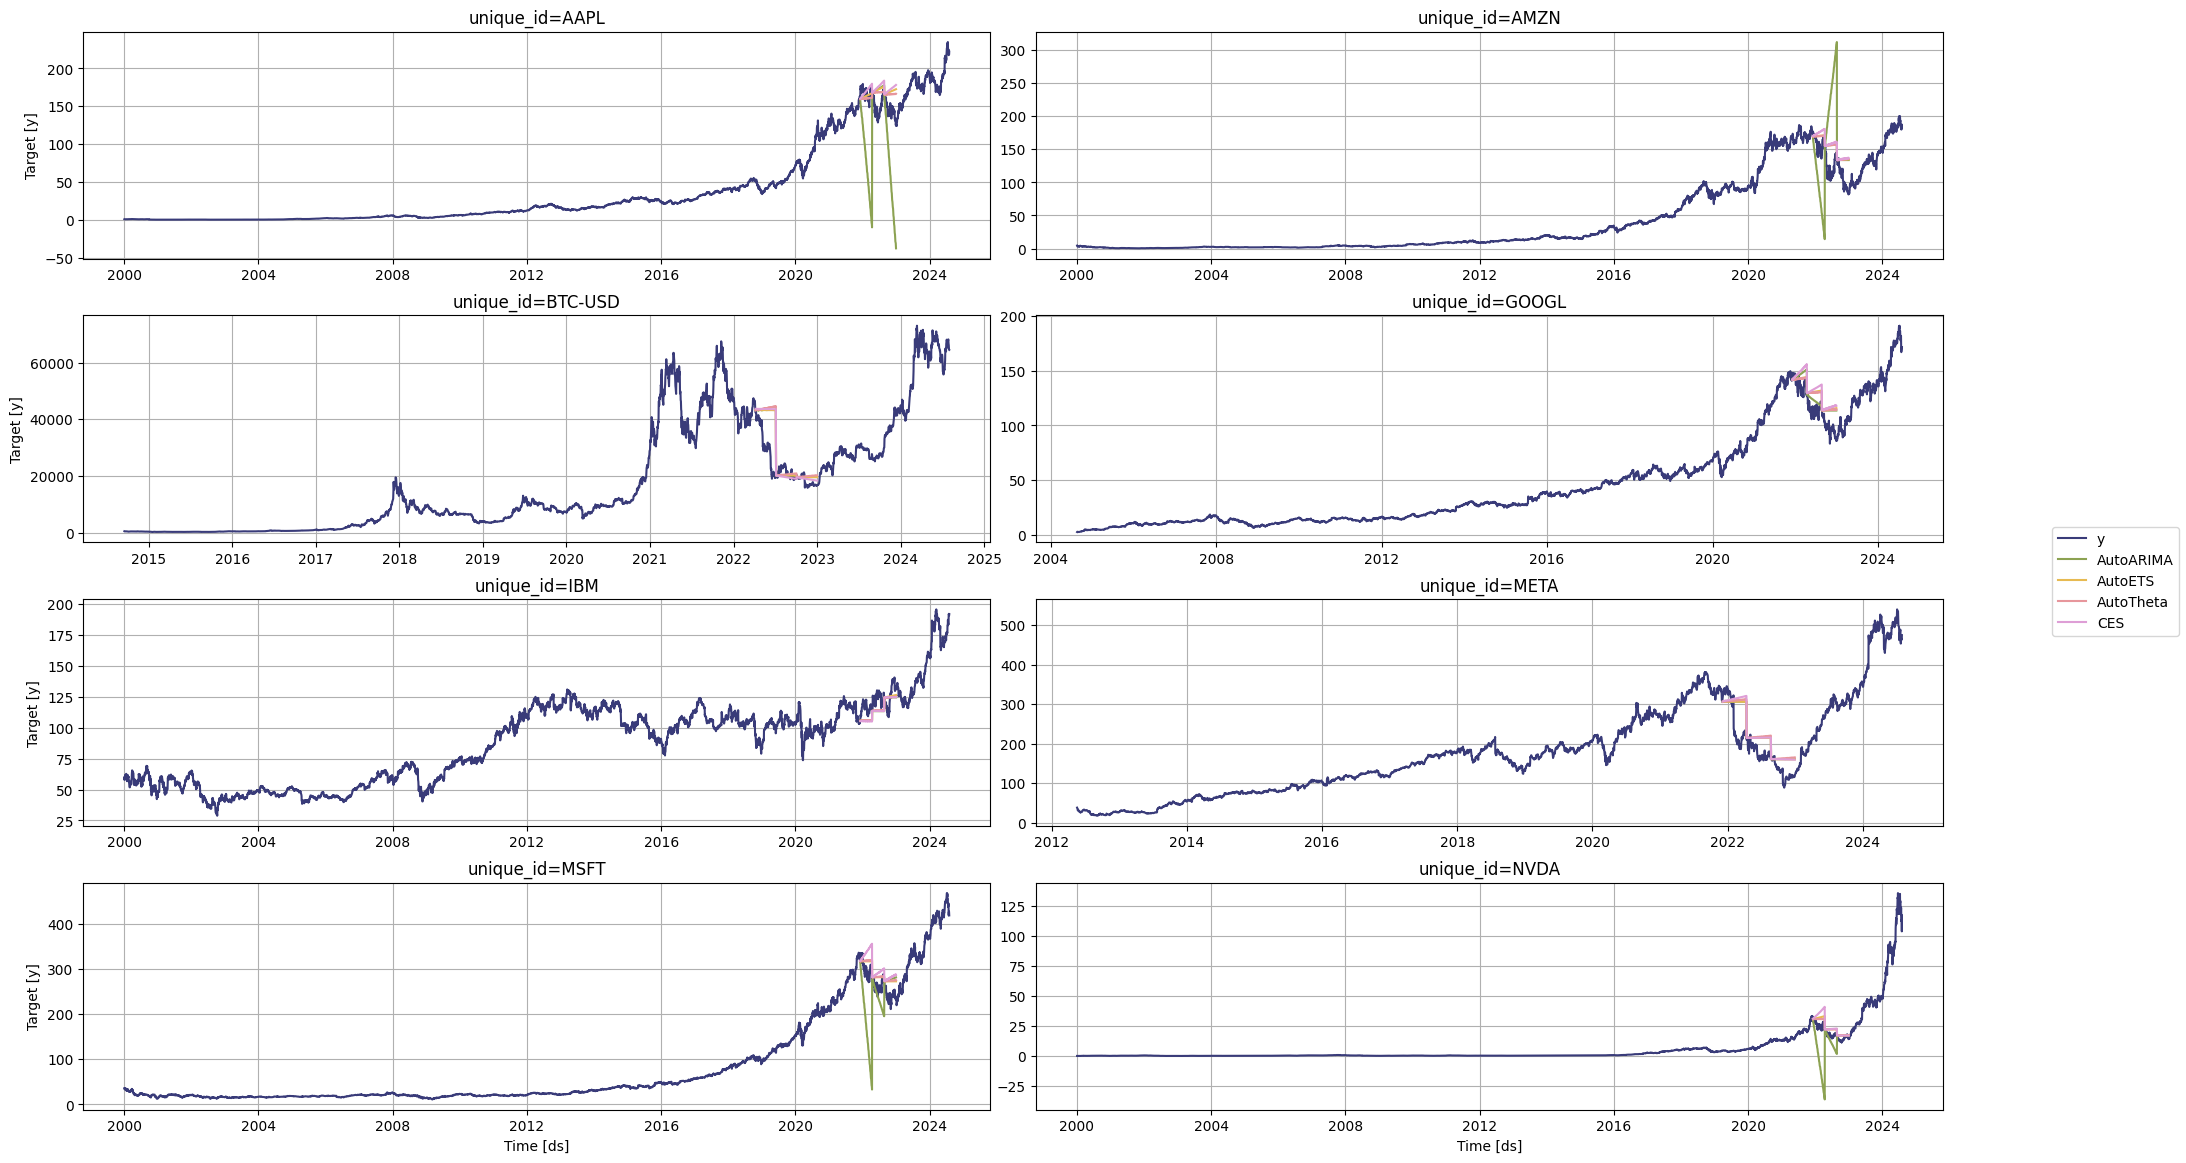

In [22]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))